# GP Applied to the Even-Parity Problem

This time we apply GP to a Boolean problem -- this has a different type and different operators, but the algorithm remains the same.

The code in this notebook is a bit tighter, that is, although slightly more difficult to read, it is a lot more reusable. First of all, here's a nice piece of code to widen our notebook to make to easier to read the output we get later on.

Install DEAP. 

In [ ]:
!pip install deap

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Import our tools as before, except this time we also include **itertools** and **networks** which contain some nice iterative tools (for creating our test set) and graph drawing functionality, respectively.

In [2]:
import operator
import math
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp


import matplotlib.pyplot as plt

import itertools
import networkx as nx



Set our Genetic Programming parameters.  Notice that these are virtually the same as the GA ones.

In [3]:
# Genetic Programming constants:
POPULATION_SIZE = 2000
P_CROSSOVER = 0.9
P_MUTATION = 0.01
MAX_GENERATIONS = 200
HALL_OF_FAME_SIZE = 10


Set the random seed. 

In [4]:
RANDOM_SEED = 412
random.seed(RANDOM_SEED)

Here are some GP-specific constants. Keeping them together like this will make later editing easier.

In [5]:
MIN_TREE_HEIGHT = 3
MAX_TREE_HEIGHT = 5
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

Some problem constants. One nice thing about this problem is that it is of scalable difficulty, so we name make it more difficult simply by increasing the number of inputs.

In [6]:
NUM_INPUTS = 6
NUM_COMBINATIONS = 2 ** NUM_INPUTS

Here's our fitness function. This is a bit more involved than before as we first create all our test cases and then write a function to calculate the party error. We declare a wrapper function, **getCost** to make this code more resuable. This way we can change the fitness function and we only need to change the name in **getCost**.

In [7]:
# calculate the truth table of even parity check:
parityIn = list(itertools.product([0, 1], repeat=NUM_INPUTS))
parityOut = []
for row in parityIn:
    parityOut.append(sum(row) % 2)
    
# calculate the difference between the results of the
# generated function and the expected parity results:
def parityError(individual):
    func = toolbox.compile(expr=individual)
    return sum(func(*pIn) != pOut for pIn, pOut in zip(parityIn, parityOut))

# fitness measure:
def getCost(individual):
    return parityError(individual), # return a tuple

Add our functions and terminals. This time we are using Boolean operators and values.

In [8]:
# create the primitive set:
primitiveSet = gp.PrimitiveSet("main", NUM_INPUTS, "in_")
primitiveSet.addPrimitive(operator.and_, 2)
primitiveSet.addPrimitive(operator.or_, 2)
primitiveSet.addPrimitive(operator.xor, 2)
primitiveSet.addPrimitive(operator.not_, 1)

# add terminal values:
primitiveSet.addTerminal(1)
primitiveSet.addTerminal(0)

Create our toolbox. This is very similar to the Symbolic Regression notebook except we are using the parameters declared up above.

In [9]:
toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on the primitive tree:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# create a helper function for creating random trees using the primitive set:
toolbox.register("expr", gp.genFull, pset=primitiveSet, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.expr)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

# create an operator to compile the primitive tree into python code:
toolbox.register("compile", gp.compile, pset=primitiveSet)

toolbox.register("evaluate", getCost)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=primitiveSet)

# bloat control:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))



Set up our population as before

In [10]:
population = toolbox.populationCreator(n=POPULATION_SIZE)
# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)   


Create a statistics object. This time we're going to use the **MultiStatistics** tool because we want to record statistics about **size** as well as **fitness**.

In [11]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


Run our GP. Notice how much slower this one is, due to the much larger population size. 

In [12]:
population, logbook = algorithms.eaSimple(population,
                                                  toolbox,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=mstats,
                                                  halloffame=hof,
                                                  verbose=True)

   	      	                    fitness                     	                     size                     
   	      	------------------------------------------------	----------------------------------------------
gen	nevals	avg   	gen	max	min	nevals	std     	avg    	gen	max	min	nevals	std   
0  	2000  	32.009	0  	40 	24 	2000  	0.671505	22.5945	0  	60 	4  	2000  	13.194
1  	1816  	31.9305	1  	40 	24 	1816  	0.6969  	23.144 	1  	69 	2  	1816  	14.243
2  	1778  	31.8885	2  	40 	16 	1778  	0.924158	24.1045	2  	81 	1  	1778  	15.3416
3  	1801  	31.865 	3  	40 	16 	1801  	1.03527 	25.423 	3  	81 	2  	1801  	16.1789
4  	1796  	31.791 	4  	40 	22 	1796  	1.12708 	26.556 	4  	92 	2  	1796  	17.4976
5  	1817  	31.6685	5  	40 	23 	1817  	1.2902  	27.6965	5  	91 	1  	1817  	18.3071
6  	1810  	31.5675	6  	38 	22 	1810  	1.48608 	30.0145	6  	113	2  	1810  	19.427 
7  	1802  	31.3585	7  	40 	20 	1802  	1.79999 	33.1   	7  	113	2  	1802  	21.2185
8  	1802  	31.089 	8  	40 	20 	1802  	2.0727  	38.025

97 	1800  	4.7065 	97 	64 	0  	1800  	10.6137 	156.182	97 	305	1  	1800  	47.106 
98 	1822  	4.8335 	98 	64 	0  	1822  	10.8131 	154.925	98 	305	24 	1822  	48.1852
99 	1809  	4.603  	99 	64 	0  	1809  	10.4983 	154.483	99 	311	18 	1809  	48.5862
100	1822  	4.407  	100	64 	0  	1822  	10.3546 	154.249	100	311	20 	1822  	47.7665
101	1777  	4.4415 	101	64 	0  	1777  	10.8377 	154.605	101	316	2  	1777  	48.2597
102	1803  	4.708  	102	64 	0  	1803  	10.6717 	155.993	102	314	24 	1803  	46.598 
103	1791  	4.083  	103	64 	0  	1791  	10.059  	153.326	103	335	10 	1791  	47.3745
104	1793  	4.234  	104	64 	0  	1793  	10.3818 	154.185	104	344	10 	1793  	48.6953
105	1786  	4.634  	105	64 	0  	1786  	10.711  	154.918	105	308	20 	1786  	49.5261
106	1822  	4.3965 	106	64 	0  	1822  	10.3277 	154.827	106	295	1  	1822  	47.9313
107	1799  	4.102  	107	64 	0  	1799  	10.0141 	153.019	107	301	18 	1799  	47.088 
108	1822  	4.383  	108	64 	0  	1822  	10.3916 	151.91 	108	287	18 	1822  	48.0502
109	1822  	4.41 

197	1776  	3.3075 	197	64 	0  	1776  	9.28838 	182.496	197	384	16 	1776  	62.2483
198	1781  	3.322  	198	64 	0  	1781  	9.35614 	183.927	198	371	22 	1781  	64.0354
199	1808  	3.2725 	199	64 	0  	1808  	9.2643  	183.779	199	424	6  	1808  	64.598 
200	1822  	3.1045 	200	64 	0  	1822  	9.30073 	183.844	200	424	15 	1822  	64.0991


Extract our statistcs. This time our logbook has *chapters* because we have maintained multiple statistics.

-- Best Individual =  xor(xor(in_2, xor(xor(not_(in_5), and_(1, or_(and_(and_(and_(in_1, in_1), xor(1, in_3)), or_(in_4, not_(in_1))), or_(in_4, in_4)))), xor(not_(xor(in_1, in_3)), and_(or_(and_(in_0, or_(in_0, in_4)), not_(and_(not_(in_5), in_5))), in_0)))), and_(0, and_(xor(or_(in_2, in_1), 1), or_(not_(in_3), not_(in_2)))))
-- length=56, height=9
-- Best Fitness =  0.0


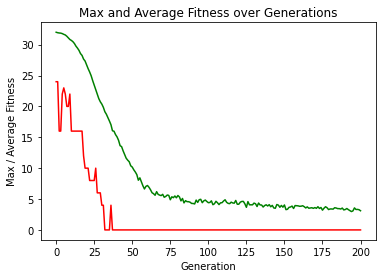

In [13]:
maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")


# print info for best solution found:
best = hof.items[0]
print("-- Best Individual = ", best)
print("-- length={}, height={}".format(len(best), best.height))
print("-- Best Fitness = ", best.fitness.values[0])

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

Now, this looks way more interesting than the Symbolic Regression graph as GP is really being made to work hard here!